# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

---

# Fundamentals of machine learning

## Generalisation: The goal of machine learning

In [1]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from IPython.display import clear_output

# we need more than the default 75 below
np.set_printoptions(linewidth=100)

plt.rcParams['lines.markersize'] = 3  # nice scatter point size

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute some annoying warnings

The fundamental tension of learning:
- *Optimization*: fit **training** data as closely as possible;
- *Generalisation*: perform on **unseen** data as best as possible.


### Overfitting, *again*!


<!-- ![Chollet canonical overfitting](images/chollet/figure5.1.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.1.png?raw=true">

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#underfitting-and-overfitting), Figure 5.1</small>

If we think about this in abstract terms, if we want our model to generalise, it needs not to take into account **every single detail** in the training data.

Because these are the things are that may not be present in unseen data.

We want our model to produce **an abstract/underlying representation** of the data, not rote learn it.

<!-- ![Chollet outliers](images/chollet/figure5.4.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.4.png?raw=true">

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#noisy-training-data), Figure 5.4</small>

The green line learns the underlying border between classes, discarding the fine-grained detail and noise in the area of uncertainty.

![Chollet ambiguous](images/chollet/overfitting-ambiguous.png)
<!-- <img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/overfitting-ambiguous.png?raw=true"> -->

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#ambiguous-features), Figure 5.5</small>

Have a look at the reference notebook for a coded example with polynomials!

### Noisy training data / Ambiguous features

Datasets can contain errors.

But also, data can be *intrinsically* ambiguous!

For instance, sometimes a hand-written 7 can be really close to a 1!

<!-- ![Chollet noisy data](images/chollet/figure5.2.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.2.png?raw=true">


<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#noisy-training-data), Figure 5.2</small>

<!-- ![Chollet mislabeled data](images/chollet/figure5.3.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.3.png?raw=true">


<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#noisy-training-data), Figure 5.3</small>

### Rare features and spurious correlations

One other danger is to **think certain features are correlated when they are not**, you simply have never seen data that contradicts your assumption.

*Example: you've known two orange tabby cats, they were antisocial. You think all orange tabby cats are, even if they are not.* [DLWP, "Rare features and spurious correlations"](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#rare-features-and-spurious-correlations).


<a href="https://twitter.com/fchollet/status/1585640324948406275?t=8r0T5VGcy5RZ_xF1L6_5Xw&s=03">
    <!-- <img style="float:right" src="images/overfitting-ikea.png"> -->
    <img style="float:right" src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/overfitting-ikea.png?raw=true">
</a>

### Experiment: adding noise to our training data

As an experiment, we can add 784 noise dimension to MNIST images and see the result.

In [11]:
(train_images, train_labels), _ = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

train_images_with_noise_channels = np.concatenate(
    [train_images, np.random.random((len(train_images), 784))], axis=1
)                 # ↑ ADDING RANDOM FEATURES (same size as the samples)

train_images_with_zeros_channels = np.concatenate(
    [train_images, np.zeros((len(train_images), 784))], axis=1
)                 # ↑ ADDING ZEROS (EMPTY) FEATURES (same size as the samples)

In [3]:
def get_model(clear=True):
    if clear:
        tf.keras.backend.clear_session()
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [5]:
# training original dataset
model = get_model()
history_orig = model.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2, # ← NOTE: Keras is so nice you can even ask it to set aside validation data for you...
    verbose=0,
)
del model

# training with noise
model = get_model()
history_noise = model.fit(
    train_images_with_noise_channels,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
)
del model

# training with zeros
model = get_model()
history_zeros = model.fit(
    train_images_with_zeros_channels,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
)
del model

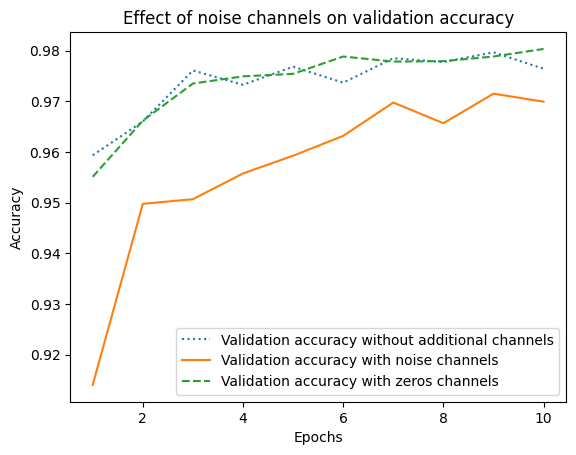

In [6]:
val_acc_orig = history_orig.history["val_accuracy"]
val_acc_noise = history_noise.history["val_accuracy"]
val_acc_zeros = history_zeros.history["val_accuracy"]
epochs = range(1, 11)
plt.plot(epochs, val_acc_orig, ":", label="Validation accuracy without additional channels")
plt.plot(epochs, val_acc_noise, "-", label="Validation accuracy with noise channels")
plt.plot(epochs, val_acc_zeros, "--", label="Validation accuracy with zeros channels")
plt.title("Effect of noise channels on validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Almost one percentage point lower validation accuracy for the noisy model despite the same information in both cases!

*The more noise channels you add, the further accuracy will degrade.* (DLWP, p.126)

The model **fits the noise** (another way of seeing overfitting).

---

## The nature of generalisation in deep learning

### Training on pure noise

A remarkable fact about deep learning models is that **they can be trained to fit anything**, as long as they have enough representational power.

For example, you can shuffle the MNIST labels and train on that!

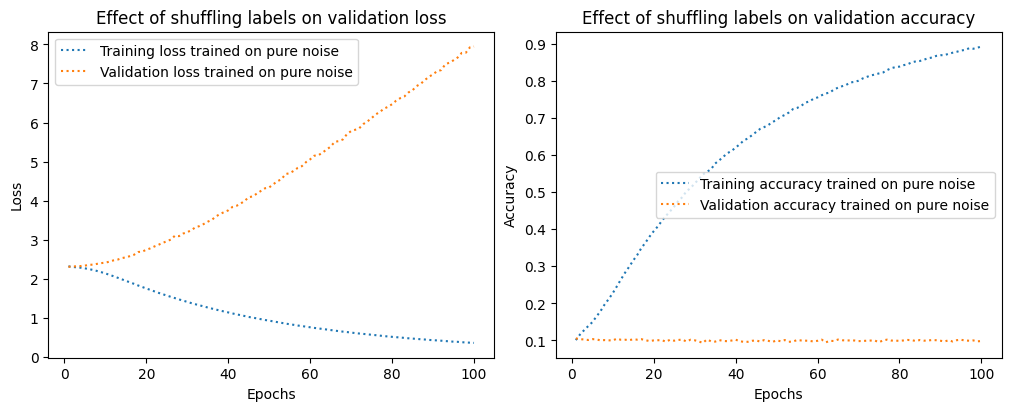

In [17]:
random_train_labels = train_labels[:]  # [:] is a nice way to guarantee you are making a copy
np.random.shuffle(random_train_labels) # shuffle the labels

model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history_pure_noise = model.fit(
    train_images, random_train_labels,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=0,
)
del model

epochs = range(1, len(acc_pure_noise) + 1)

loss_pure_noise = history_pure_noise.history["loss"]
val_loss_pure_noise = history_pure_noise.history["val_loss"]
acc_pure_noise = history_pure_noise.history["accuracy"]
val_acc_pure_noise = history_pure_noise.history["val_accuracy"]

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, constrained_layout=True, figsize=(10,4))

ax1.plot(epochs, loss_pure_noise, ":", label="Training loss trained on pure noise")
ax1.plot(epochs, val_loss_pure_noise, ":", label="Validation loss trained on pure noise")
ax1.set_title("Effect of shuffling labels on validation loss")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(epochs, acc_pure_noise, ":", label="Training accuracy trained on pure noise")
ax2.plot(epochs, val_acc_pure_noise, ":", label="Validation accuracy trained on pure noise")
ax2.set_title("Effect of shuffling labels on validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()

plt.show()

If you do that, you find that:

- the **loss** *still* goes down (although learning is far easier when the labels are meaningful)
- the **validation loss** tends to diverge, and certainly does not go down!
- your **validation accuracy** will be, in our case, around 0.1: *random guessing*!

But this is a fascinating phenomenon: you can generate random data points and labels, and your network **will** learn them.

So, how come networks *do* learn something and generalise?

In [ ]:
del train_images_with_noise_channels, train_images_with_zeros_channels

### The manifold hypothesis

#### Note: Manifolds

**Manifold** is the topological generalisation of a surface (like tensors with vectors and matrices).

Technically: a manifold **locally resembles Euclidean space near each point** ([Wikipedia](https://en.wikipedia.org/wiki/Manifold)).

The Earth's surface looks flat from our (sufficiently local) perspective.

A line is an example of a 1D manifold. A plane, but also the surface of a sphere, or a torus (doughnut), are all 2D manifolds. And of course this doesn't stop there, this works in any dimension.

<!-- ![Brian Keng circle manifold](images/bjlkeng.manifold-circle.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/bjlkeng.manifold-circle.png?raw=true">

"A circle is a one-dimensional manifold embedded in two dimensions where each arc of the circle locally resembles a line segment."  
<small>Source: [Brian Keng, "Manifolds: A Gentle Introduction"](https://bjlkeng.github.io/posts/manifolds/), itself taken from: [Manifold, Wikipedia](https://en.wikipedia.org/wiki/Manifold#Circle)</small>

#### Data is (usually) highly structured

The idea comes from the fact that our data is **highly structured**.

Our network can learn that structure, instead of, as said, *rote-learning*/*memorising* the data.

We are not at all learning **all possible 28x28 images** ($255^{784}\ \text{possibilities!}$), only a tiny subset.

You can easily imagine that *most* possible images are not MNIST digits...

What is more, we can make the *hypothesis* that the subset of digits is in fact a **manifold** within the space of possible 28 x 28 `uint8` arrays.

If the space of MNIST digits is a manifold:
- it is **continuous**: if you modify a sample a little, it is still recognisable;
- all as samples are **connected** (you can travel from one to the other without jumps).

What does this mean for us?
- Machine learning models only have to fit **relatively simple, low-dimensional, highly structured subspaces** within their potential input space (latent manifolds).
- Within one of these manifolds, it’s always possible to **interpolate between two inputs**, that is to say, morph one into another via a continuous path along which all points are still valid points, still on the manifold (MNIST digits).

![Chollet MNIST morphing](images/chollet/figure5.7.png)
<!-- <img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.7.png?raw=true"> -->

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#the-manifold-hypothesis), Figure 5.7</small>

#### Interpolation as a source of generalisation

So, if you have been able to learn that manifold, you can start making sense of points you’ve never seen before by **relating them to other points that lie close on the manifold**.

You can make sense of the **totality** of the space using only a **sample** of the space.

<!-- ![Chollet ](images/chollet/figure5.8.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.8.png?raw=true">

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#interpolation-as-a-source-of-generalization), Figure 5.8</small>

However, one should remember this is only *one* aspect of generalisation.

The tip of the iceberg, and only working for *close* points: **local generalisation**.

In Chollet's theory, humans are capable of much more: **extreme generalisation**.

This was exposted in his article, [*On the Measure of Intelligence*](https://arxiv.org/abs/1911.01547), 2019, arXiv:1911.01547, see also the video in the reference notebook.

#### Why deep learning works

A deep learning model is basically:
- a very high-dimensional curve that is smooth and continuous, (required for gradient descent), an approximation of the data manifold;
- you can also see it as **finding the appropriate projection** of the data into the structured space (the manifold).

#### The Curse of Dimensionality

The [**curse of dimensionality**](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is actually one of the real challenges in Deep Learning.

When your data is distributed in a very high-dimensional space, data points have barely **any neighbours**.

The space is very **sparse** (very few data points compared to all possibilities).

That is because **one dimension is enough** for two points to be far apart.

*Example: MNIST images. 784 pixels, each indpendent of each other, thus considered the __dimensions__ of the space of possible images. What are the chances that, given two images of a number, __all__ pixel values are really close to each other (↔ the coordinates of the two images are close)?*

In [9]:
def plot_distant_points():
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    p1 = (6,5,0)   # the two points are very close in the two first dims
    p2 = (5,6,10)  # but one dimension is enough to draw them apart

    p12 = (6,5,10)   # the two points are very close in the two first dims
    p22 = (5,6,0)   # the two points are very close in the two first dims

    ax.set_xlim([0,12])
    ax.set_ylim([0,12])
    ax.set_zlim([0,12])

    ax.scatter(*p1, marker='o', c='b', s=100, label=f"Point 1:  {p1}")
    ax.scatter(*p2, marker='x', c='b', s=100, label=f"Point 2:  {p2}")

    ax.scatter(*p12, marker='o', c='coral', label=f"Point 1': {p12}")
    ax.scatter(*p22, marker='x', c='coral', label=f"Point 2': {p22}")

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.legend()
    plt.show()

A 3D example. Two points are close to each other in the first two dimensions, but the third dimension sets them apart. What is the chance for two points to be close if there are 784 dimensions?

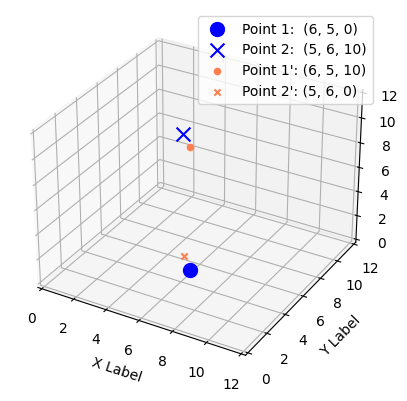

In [10]:
plot_distant_points()

*Other example: given the interval $[0,1]$, if you placed 4 data points every $0.2$, you can cover the space evenly. Now, for a square, how many points do you need to have a similar coverage? $4^2 = 16$. And for a cube? $4^3 = 64$. The number of data points you need to obtain a uniform, good coverage of your space grows exponentially with the number of dimensions!*

See [this page](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Sampling) as well.

This is why **training data is paramount**! The more data you train on, the better you cover the space, and the better you can fit!

---

## Evaluating machine-learning models

### Training, validation, and test sets

Models are not evaluated on their training data because we want **generalisation** – the ability to make good predictions on new, unseen data.

Predictive power on unseen data can **worsen** even though the fit to training data **improves**.

We need stategies to limit overfitting and maximise generalisation.

Remember, the reason we use a **validation set** on top of our **test set** is:

We wish to find good **hyperparameter** settings!

Hyperparameters are tuned by considering their effect on a validation set.

**We** inject into our model information about that validation set every time a hyperparameter is tuned.

The more experiments we perform, the more information from that set **leaks** into our model.


Thus, we cannot possibly consider the validation set **unseen data**.

At the end of the tuning process, the model is actually optimised for the validation set.

And generalisation can still be checked by evaluating our model on our **(unseen) test data**.

### Three validation techniques

- Simple hold-out validation
- K-fold validation
- Iterated K-fold validation with shuffling

#### Simple hold-out validation

Basic setup (common in big data settings):

<!-- <img style="height:350px;float:right" src="images/chollet/figure5.12.png"> -->
<img style="height:350px;float:left" src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.12.png?raw=true">

<small  style="position:absolute;left:0;bottom:0">DLWP, p.134</small>

Our setup (theoretically better!):


<!-- <img style="height:300px;float:right" src="images/training-validation-test.png"> -->
<img  style="height:300px;float:right" src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/training-validation-test.png?raw=true">

<small style="position:absolute;right:0;bottom:0">["Training, Validation and Test sets 차이 및 정확한 용도 (훈련, 검정, 테스트 데이터 차이)"](https://modern-manual.tistory.com/m/19)</small>

Note that even the second technique is vulnerable to statistical fluctuation if the validation and test set are small.

You can notice this if different rounds of **shuffling** yield **validation variance** (= validation results are very variable).

#### K-fold validation

What we've seen last time, see the previous notebooks for the code.

<!-- <img  style="float:right"  src="images/chollet/figure5.13.png"> -->
<img  style="float:right"  src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.13.png?raw=true">


<small style="position:absolute;right:0;bottom:0">[DLWP], p.135</small>

#### Iterated K-fold validation with shuffling

In a variant known as **iterated** or **repeated** K-fold validation, K-fold validation is repeated $P$ times.

Each time, the dataset is shuffled, leading to different partial training and validation sets!

The K-fold averages are gathered and re-averaged.

$P \times K$ models are trained and evaluated – this is expensive!

```python
iterated_val_scores = []
             # ↓ repeat P times
for _ in range(P):      # ↓ shuffle train and validation sets together
    shuffled_indz = np.random.permutation(train_val_dataset.shape[0])
    train_val_dataset = train_val_dataset[shuffled_indz]
    train_val_labels = train_val_labels[shuffled_indz]
                        # ↓ do K-fold validation (trains K-models!)
    k_fold_val_scores = k_fold_validation(train_val_dataset)
                               # ↓ save the mean this round of K-fold validation
    iterated_val_scores.append(np.mean(k_fold_val_scores))
# the iterated average is the mean of the P K-fold score means
avg_iterated_age_val_score = np.mean(iterated_val_scores)  
```

This method is useful when **little** data is available.

In more and more deep learning contexts, we are dealing with **heaps** of data!   

K-fold is then both too expensive and not relevant...

---

## Beating a common-sense baseline

Because deep learning is somewhat opaque, it is important to have an idea of what simpler methods achieve.

The simplest of all methods is a random classifier (use _if the dataset is balanced_): just **a random guess**.

The second most simple (_if the dataset is imbalanced_): only predict **the most prevalent class**.

*If your dataset has 90% of class A, and 10% of class B, a model that **always** predicts A will get .9 accuracy, you need to beat that!*

In the case of regression, there is more diversity, as estimating this depends on the structure of the problem, but a common approach is to predict **the mean of the data**.

---

## Things to keep in mind about model evaluation

### The training and test data should be representative

- Train set, validation set *and* test set  must come **from the same distribution**;
- That means: they **must contain a bit of everything**.


_For example, suppose in the MNIST problem that the images come sorted by digit. Clearly, the test set and training sets will contain different classes, not good! This is easily remedied by **shuffling**._

### Beware the arrow of time!

- Don't shuffle time-ordered data (e.g. weather and stock prediction)!
- Make sure the training does not allow your model to just cheat and look up the solutions (causality/look ahead).

### Avoid data redundancy (as much as possible):

- A data point not uncommonly occurs twice or more in real world data;
- The risk is doing testing on data that was present in the training set;
- **Ideally**, you have to ensure that the training and test sets are **disjoint**.

*Good luck if you train on the entire Internet...  (⇀‸↼‶)*

---

## Improving model fit

One side of our problem is **not being able to fit** the data (we don't really encouter that here, but for larger datasets that will happen).

Then, what we want is **increasing the power (capacity)** of our model.

## Increasing model capacity

Let's compare two models and their respective performance.

### Code: train

In [18]:
tf.keras.backend.clear_session()
batch_size = 128

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="softmax") # ← ONE LAYER
])
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history_small_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0
)
del model

# bigger model
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation="relu"),    # ← THREE LAYERS, more neurons
    tf.keras.layers.Dense(96, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
history_large_model = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0
)
del model

### Code: plot

In [19]:
def plot_two_losses(losses1, losses2, epochs=range(1,21), share_axes=False):
    if share_axes:
        fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, constrained_layout=True, sharex=True, sharey=True, figsize=(10,4))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, constrained_layout=True, figsize=(10,4))

    ax1.plot(epochs, losses1, "b--", label="Validation loss small")
    ax1.set_title("Effect of insufficient model capacity on validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(epochs, losses2, "r--", label="Validation loss large")
    ax2.set_title("Effect of sufficient model capacity on validation loss")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    plt.show()

#### First plots

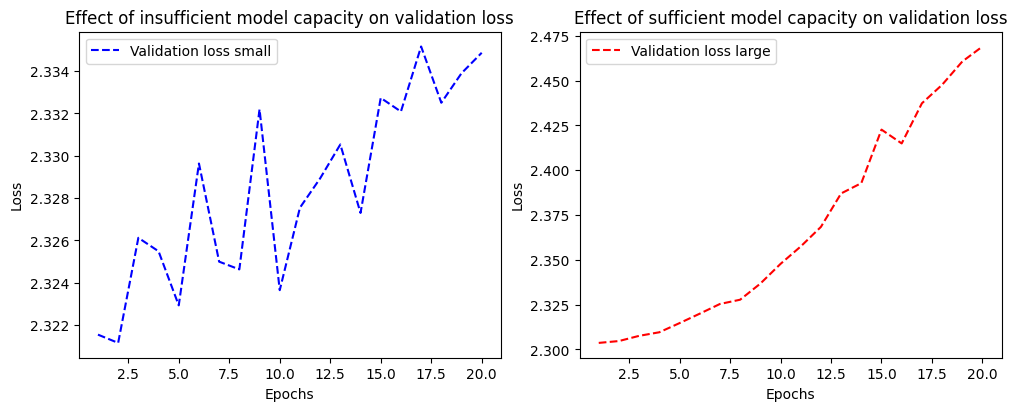

In [20]:
val_loss_small = history_small_model.history["val_loss"]
val_loss_large = history_large_model.history["val_loss"]
plot_two_losses(val_loss_small, val_loss_large)

**Note: scale matters!**

**Never** forget to keep the scales of the axes in mind! What we saw is a reproduction of what you find in DLWP, 141-2. However, if you force the axes to be at the same scale, the picture is somewhat different: you clearly see the insufficient capacity model stagnating, but your overfitting model is **overall better**! (You would need to train it longer to degrade the validation loss beyond what the simpler model does.)

#### Scaled plots

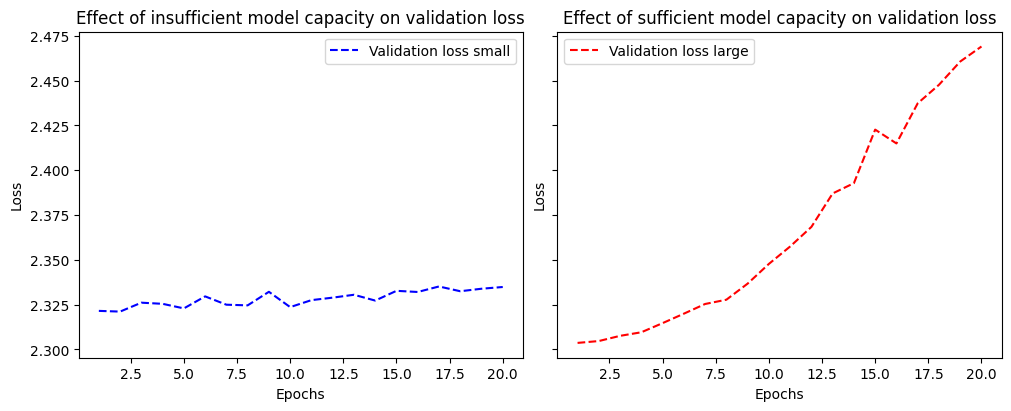

In [21]:
val_loss_small = history_small_model.history["val_loss"]
val_loss_large = history_large_model.history["val_loss"]
plot_two_losses(val_loss_small, val_loss_large, share_axes=True)

In [16]:
del train_images, train_labels

---

## Improving generalisation

Once we are able to overfit, we want to make sure our gains will **remain valid on unseen data**.

That's the other side of our problem.

What we aim for is a *middle ground* between performing on known *and* unknown data!

## Dataset curation

- **More data is better!** Make sure you have enough data.
- Minimize labeling errors: visualize your inputs to check for anomalies, and proofread your labels.  
  **Knowing your data well will help you!**
- Clean your data and deal with missing values.  
  (Beware! Real data in production might not be clean... → not the same distribution!)
- Look at your **features**, remove useless ones if necessary.

## Feature engineering

Feature engineering is data preprocessing in the light of human knowledge of the data and the workings of a neural network.

Feature engineering was critical pre-DL since shallow networks do not have a large hypothesis space.

DL networks, thanks to their large hypothesis space, are less dependent on feature engineering.

Feature engineering can still relevant because it helps us to solve problems cheaply and elegantly and with less data.

The smaller the training set, the greater the need for feature engineering.

The opposite is usually true: **if you work at scale, feature engineering tends to lose out**.

### Example: learning to tell the time

- suppose the input data is a pixel map of a clock face;

- this is a difficult machine learning task;

- requires convolutional nets and a vast data set of clock faces.

- Feature engineering might extract the x, y coordinates of the hands;

- the problem then becomes tractable;

- in fact the problem can be solved by a formula – the angle of the hands.

<!-- ![Chollet features time](images/chollet/figure5.17.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.17.png?raw=true">


<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#feature-engineering), Figure 5.17</small>

---

## Using early stopping

Deep learning models are most of the time (very) **overparameterised**.

They have way more parameters (degrees of freedom) than what is needed to fit the data.

This is not a problem, as we *don't fit the data perfectly*.

---

## Regularising your model

Our experience with classification of movie reviews and newswires shows that model performance on validation data peaks and then decreases with training.

Because of this, we seek a balance between:
- **optimisation** (of training data) and
- **generalisation** (to test data).

### Data: More Is More!

Often the easiest, and almost always the best remedy to overfitting is to find **more training data**.

**Note: limited data?**

*We need solutions for when the data is limited. (；⌣̀_⌣́ )*

**Note: what if we underfit?**

More data won't help you if you **underfit**!

### More regularisation techniques

-  network size/capacity reduction
-  weight regularisation (L1/L2)
-  dropout

### Reducing the network’s size

#### Finding the right capacity

Network **capacity** is simply the number of learnable  parameters (weight and bias parameters).

Between a low capacity model, likely to **underfit** our training data, and a high capacity one, that **fits the training data perfectly and fails to generalise**, there might be one that is just right!

The goal is a model with *sufficient but limited* capacity.

Such a model will be forced to learn **compressed representations** (the **underlying manifold**) – which then gives it predictive power.

The ideal number of layers and number of units in each layer is unknowable in advance .

#### Workflow

- Start with a low capacity model and
- increase capacity until validation gains flatten out.

#### Code: train three nets of different sizes

Let's compare a small and a large network to the original IMDB network.

A three layer model building function. Two `relu` layers followed by a `sigmoid` layer for the output of a probability.

In [22]:
def build_model(layer_1_units, layer_2_units, layer_3_units, clear=True):
    if clear: # O gods of GPU memory, have mercy upon us
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((10000,)))
    model.add(tf.keras.layers.Dense(layer_1_units, activation='relu'))
    model.add(tf.keras.layers.Dense(layer_2_units, activation='relu'))
    model.add(tf.keras.layers.Dense(layer_3_units, activation='sigmoid'))
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model

The original network. 160,305 trainable parameters.

In [23]:
model = build_model(16, 16, 1)
model.summary()
del model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │       160,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)

A small (low capacity) network with about one quarter the capacity of the original network.

In [24]:
model = build_model(4, 4, 1)
model.summary()
del model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │        40,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,029 (156.36 KB)

 Trainable params: 40,029 (156.36 KB)

 Non-trainable params: 0 (0.00 B)

A larger (high capacity) network – 32 times original capacity.

In [25]:
model = build_model(512, 512, 1)
model.summary()
del model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     5,120,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,383,681 (20.54 MB)

 Trainable params: 5,383,681 (20.54 MB)

 Non-trainable params: 0 (0.00 B)

#### Code: load and preprocess dataset

In [26]:
((train_data, train_labels), (test_data, test_labels)) = tf.keras.datasets.imdb.load_data(num_words = 10000)

def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros( (len(sequences), dimension) )
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#### Code: a nice callback

The same as last time.

See this [tutorial](https://www.tensorflow.org/guide/keras/custom_callback) for more.

In [27]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, epochs):                                            # by passing epochs at initialization
        super(tf.keras.callbacks.Callback, self).__init__()                # I can use this as our total in on_epoch_begin
        self.epochs = epochs
    def on_epoch_begin(self, epoch, logs=None):                            # run at the start of each epoch
        c = ['|', '/', '-', '\\']
        print(f"\r{c[epoch % 4]} epoch: {epoch+1}/{self.epochs}", end="")  # run at the very end of training
    def on_train_end(self, logs=None):
        print()

#### Code: modular programming – a loop for building and training three networks

The networks are named according to the number of units in each layer and the histories are saved in a dictionary. The progress spinner rotates slowly on the large network because there are many more parameters to train in each epoch.

In [28]:
histories = {}
for i in [4, 16, 512]:
    model = build_model(i, i, 1)                      # Build models:
    model_name = f"{i}-{i}-1"                         # '4-4-1', '16-16-1', '512-512-1'
    print('Training', model_name)
    history = model.fit(                              # Train & validation
        x_train,
        y_train,
        epochs=20,
        batch_size=512,
        validation_split=0.4,
        verbose=0,
        callbacks=[CustomCallback(20)]                # ← same lovely callback as last time
    )
    histories[model_name] = history                   # Save history in a dictionary
    del model

Training 4-4-1
\ epoch: 20/20
Training 16-16-1
\ epoch: 20/20
Training 512-512-1
\ epoch: 20/20


#### Code: plot results

In [29]:
def plot_loss_comparison(loss_a, label_a, loss_b, label_b, y_label, save=False): # IDEA FOR COURSEWORK: can you
    """A plot function for comparing two losses."""                              # modify this function so as to
    epochs = range(1, len(loss_a) + 1)                                           # accept any number of models, not
    plt.plot(epochs, loss_a, 'b-', label = label_a)                              # just two? Perhaps packing a
    plt.plot(epochs, loss_b, 'r--', label = label_b)                              # single model's data into a list,
    plt.xlabel('Epochs')                                                         # and looping through your list of
    plt.ylabel(y_label)                                                          # lists to plot the data?
    plt.legend()
    if save:
        plt.savefig('overfitting.png', format='png')                             # save image locally
    plt.show()

The low capacity starts overfitting later and at a slower rate than the original network

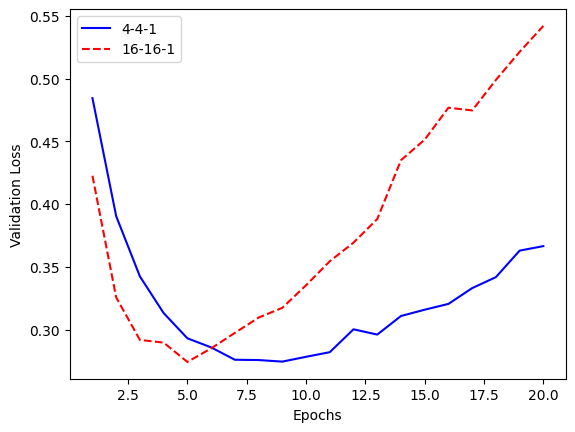

In [30]:
net_a, net_b = '4-4-1', '16-16-1'
plot_loss_comparison(
    loss_a=histories[net_a].history['val_loss'], label_a=net_a,
    loss_b=histories[net_b].history['val_loss'], label_b=net_b,
    y_label='Validation Loss'
)

The high capacity network overfits almost at the outset, and more vigorously.

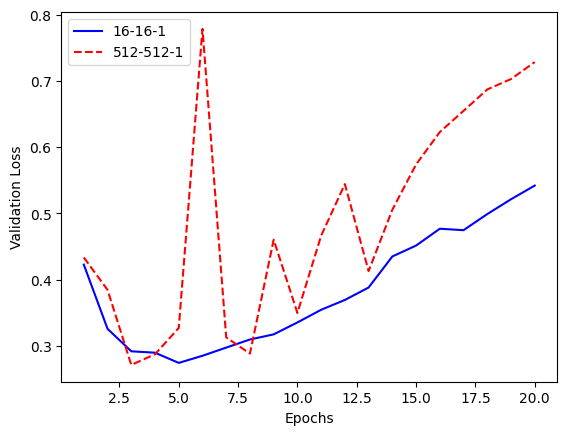

In [31]:
net_a, net_b = '16-16-1', '512-512-1'
plot_loss_comparison(
    loss_a=histories[net_a].history['val_loss'], label_a=net_a,
    loss_b=histories[net_b].history['val_loss'], label_b=net_b,
    y_label='Validation Loss'
)

The high capacity network reaches zero training loss earlier than the original network. The high capacity network easily models training data – at the expense of overfitting.

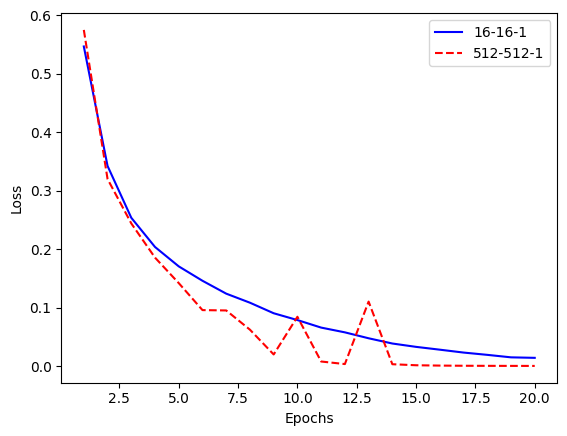

In [32]:
net_a, net_b = '16-16-1', '512-512-1'
plot_loss_comparison(
    loss_a=histories[net_a].history['loss'], label_a=net_a,
    loss_b=histories[net_b].history['loss'], label_b=net_b,
    y_label='Loss'
)

### Adding weight regularization (L1/L2)

#### Continuous capacity control

A simple network has low capacity (small number of units) and small weight and bias values.

In analogy with polynomial fits of points, **simple** means low capacity, equivalent to a low degree.

What if we had a way of controlling the capacity in a **continuous, smooth way**?

Weight regularisation is a way to do that.

Parameters are **regular** if they occupy a small interval close to zero:

- large weight parameters will amplify input noise (just like larger coefficients in a polynomial);
- the network will attempt to fit the noise;
- a model with smaller weight will behave like a **lower capacity model**.


*An example: the `tanh` activation is almost linear around zero. With small weights, the network tends to behave like a linear model!*

#### Weight regularisation

- L1: a cost proportional to the **absolute value** of the weight parameters is added to the loss function;

- L2: as above, but the cost is the **square** of the weight parameters.

L2 is more often used! It is also known as **weight decay**, in-depth explanation by Andrew Ng in the references.

These regularisation terms are added to the loss function, and **penalise the network if it has large weights**.

#### TensorFlow syntax

TensorFlow Keras weight parameter regularisation is achieved by adding a weight regularizer instance to the layer you are using:

```python
tf.keras.layers.Dense(
    16,
    # ↓ REGULARISATION -------------------------------
    kernel_regularizer=tf.keras.regularizers.l2(0.001),
    activation='relu'
)
```                         

`l2(0.001)` $0.001 \times \sum(w^T \cdot w)$ is added to the loss function ($0.001 \times \sum|w|$ for `l1(0.001)`).

L1, or a combination, are selected like so:

```python
    # ↓ ------------------------------------ ↓ L1 ---
    kernel_regularizer=tf.keras.regularizers.l1(0.001),
```  
```python
    kernel_regularizer=(
        # ↓ ----------------- ↓ L1 ---- combined with --------- ↓ L2 ! --
        tf.keras.regularizers.l1(0.001) + tf.keras.regularizers.l2(0.001)
    )
```       
```python
    # or, same as the previous one:
    # ↓ -------------- ↓ ----------------- ↓ L1 and L2,
    kernel_regularizer=tf.keras.regularizers.l1_l2(0.001, 0.001)
```     

#### L1/L2 regularisation: math reference

$$
\bbox[5px,border:2px solid red]
{
\begin{align*}
\mathrm{L1}&: J(w,b) = \frac{1}{m} \sum Loss(y_{pred}, y) + \color{blue}{\frac{\lambda}{m} |w|} \quad (\text{equivalent to} \lVert w \rVert_1)\\
\\
\\
\mathrm{L2}&: J(w,b) = \frac{1}{m} \sum Loss(y_{pred}, y) + \color{blue}{\frac{\lambda}{2m} \lVert w \rVert^2_2}\\
\end{align*}
}
$$

L1 regularisation is also known as [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)).  

L2 regularisation is also known as [Ridge](https://en.wikipedia.org/wiki/Ridge_regression) (or Tikhonov regularisation).

See also [this](https://en.wikipedia.org/wiki/Regularization_(mathematics)#L1_and_L2_Regularization).

$J$: final loss over all training examples    
$w$: weights  
$b$: biases  
$y_{pred}$: model predictions  
$y$: true labels  
$m$: number of samples   
$|w|$: the absolute value of the elements  
$\lVert w \rVert^2_2$: the sum of the squares of the elements (equivalent to $w^Tw$)  
$\lambda$: the regularisation (hyper)parameter: how strong you wish this regularisation to be...

Note: the scaling by $\frac{1}{m}$ of the regularisation term is mentioned by [Andrew Ng](https://www.youtube.com/watch?v=NIiZZY7nlfU&t=266s) as helping to find a value of $\lambda$ that is more robust to changes in $m$, however that seems to apply more to classical cases of regression: in the TensorFlow implementation, not only is that penalty applied to the weights of _individual layers_, rather than to all weights, as is usually demonstrated when teaching the subject, but the scaling by $\frac{1}{m}$ is also not applied. Moreover, the other scaling by $\frac{1}{2}$ in the L2-norm case (which sometimes appears in the literature with L1 as well, but less often than not), is present as a way of facilitating the derivation of the gradient: when this is automated by a library like TensorFlow, it is also omitted.

#### Code: modular programming – a model building function with optional regularisation

Let us compare L2 regularisation to the unregularised IMDB network.

In [33]:
def build_model(layer_1_units, layer_2_units, layer_3_units, reg=True, clear=True):
    if clear:                                               # ↑ REGULARISATION parameter
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()

    model.add(tf.keras.Input((10000,)))

    model.add(
        tf.keras.layers.Dense(
            layer_1_units,     # ↓ REGULARISATION (only if reg is True) --------
            kernel_regularizer=tf.keras.regularizers.l2(0.001) if reg else None,
            activation='relu'
        )
    )

    model.add(
        tf.keras.layers.Dense(
            layer_2_units,     # ↓ REGULARISATION (only if reg is True) --------
            kernel_regularizer=tf.keras.regularizers.l2(0.001) if reg else None,
            activation='relu'
        )
    )

    model.add(tf.keras.layers.Dense(layer_3_units, activation='sigmoid'))
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc']
    )
    return model

In [34]:
model = build_model(16, 16, 1, reg=False) # NO REGULARISATION
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
    verbose=0,
)
del model

In [35]:
l2_model = build_model(16, 16, 1, reg=True) # WITH L2 REGULARISATION
l2_history = l2_model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
    verbose=0,
)
del l2_model

The L2 regularised model resists (or delays) overfitting even though both networks have the same capacity  
(160'305 learnable parameters).

#### Code: plot results

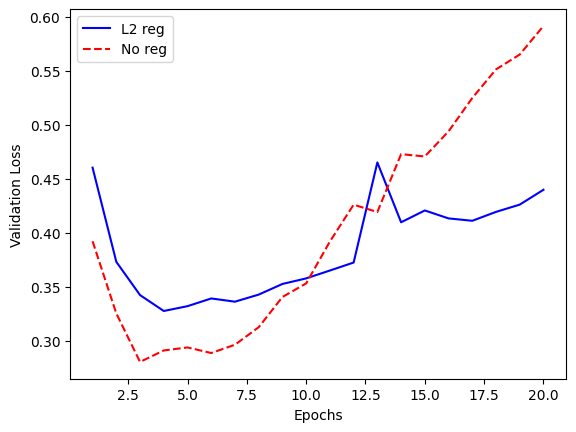

In [36]:
plot_loss_comparison(
    l2_history.history['val_loss'], 'L2 reg',
    history.history['val_loss'], 'No reg',
    'Validation Loss'
)

### Dropout

#### What is Dropout?

Finally, dropout is a common and effective regularisation technique.

A fraction ('the dropout rate') of the output from a dropout layer is zeroed.

![Chollet dropout](images/chollet/figure5.21.png)
<!-- <img src="https://github.com/jchwenger/AI/blob/main/lectures/04/images/chollet/figure5.21?raw=true"> -->

<small>[DLWP](https://deeplearningwithpython.io/chapters/chapter05_fundamentals-of-ml/#adding-dropout), Figure 5.21</small>

#### Dropout: manual implementation

In [37]:
# dropout rate = 0.5
length = 8
mask = np.random.randint(0, high=2, size=length) # the mask is a vector with, on average,
with np.printoptions():                          # equal numbers of zeros and ones (a rate of 0.5)
    print('mask =', mask)
    print()

layer_out = np.random.rand(length)

with np.printoptions(linewidth=120):
    # layer output
    print('layer_out        =', layer_out)

    # regularised layer output
    print('mask * layer_out =', mask * layer_out) # dropout is just multiplying the layer output by the mask

mask = [0 1 0 1 0 0 0 0]

layer_out        = [0.00696667 0.53140989 0.66866745 0.75586841 0.43556626 0.33700555 0.35966994 0.80018224]
mask * layer_out = [0.         0.53140989 0.         0.75586841 0.         0.         0.         0.        ]


The dropout rate is usually between 0.2 and 0.5.

Dropout is removed while evaluating the final network.

#### Note

In order to **keep the expected value** of activations constant between the net with and without dropout, the
 output activations after activation need to be **scaled up by the dropout rate** to compensate for the parts of the layer output removed by dropout. Indeed, in expectation the output activation of the layer will be reduced by the dropout rate (50% in our case) as 50% of the elements are zeroed out.

```python
layer_output *= np.random.random(0, high=2, size=layer_output.shape)
layer_output /= 0.5
```

TensorFlow applies this scaling automatically.

#### Code: modular programming – a model building function with optional 50% dropout

In [38]:
def build_model(layer_1_units, layer_2_units, layer_3_units, drop, clear=True):
    if clear:                                               # ↑ DROPOUT parameter
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((10000,)))

    model.add(tf.keras.layers.Dense(layer_1_units, activation='relu'))
    if drop:                      # ↓ DROPOUT                        # IDEA FOR COURSEWORK: instead of drop being
        model.add(tf.keras.layers.Dropout(0.5))                      # a boolean, how about passing the *rate*,
                                                                     # and only activating the layer if it is > 0 ?
    model.add(tf.keras.layers.Dense(layer_2_units, activation='relu'))
    if drop:                      # ↓ DROPOUT                        # ALSO: can you find a way to combine layer
        model.add(tf.keras.layers.Dropout(0.5))                      # automation with specifying a dropout rate
                                                                     # for each layer?
    model.add(tf.keras.layers.Dense(layer_3_units, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

#### Code: compare models with and without dropout (& plot)

In [39]:
model = build_model(16, 16, 1, drop=False) # training the original network
history = model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
    verbose=0,
    callbacks=[CustomCallback(20)]
)
del model

\ epoch: 20/20


In [40]:
do_model = build_model(16, 16, 1, drop=True) # training a network with dropout
do_history = do_model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=512,
    validation_split=0.4,
    verbose=0,
    callbacks=[CustomCallback(20)]
)
del do_model

\ epoch: 20/20


The plot show that dropout has successfully reduced overfitting.

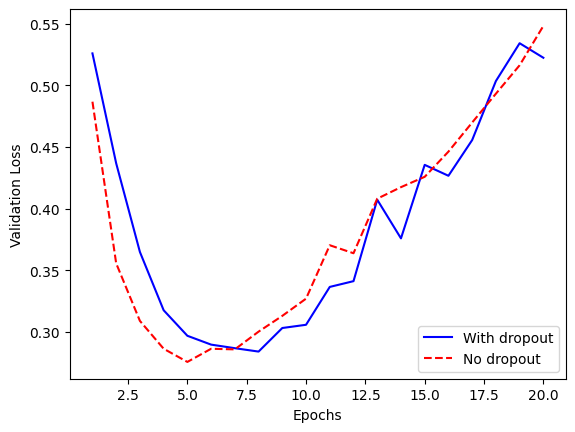

In [41]:
plot_loss_comparison(
    do_history.history['val_loss'], 'With dropout',
    history.history['val_loss'], 'No dropout',
    'Validation Loss'
)

---

# Summary

## Workflow

1. **Define** the problem and **collect data** (samples and labels)
2. Choose the **success criterion** (**loss**) and monitoring **metrics**
3. Chose a **validation protocol** (hold-out...)
4. **Prepare your data**
5. Check your **baselines**
5. **Train**  
   a. a first underfitting model (still with statistical power, not a total wreck)  
   b. a larger overfitting model  
7. **Tune**  
   a. **Regularise** the overfitting model  
   b. **Tweak** hyperparameters based on performance on the **validation set**  
8. **Retrain on the entire training set** and evaluate on your **unseen test set**

## Overfitting

- **More data** is better. (By far the best and most straightforward measure...)

Other techniques:

- **Capacity reduction**
- **Weight regularisation**
- **Dropout**

## Statistical power

We aim for statistical (predictive) power.

- Establish a **baseline** will help you know what to aim for;
- Grow your model until you beat the baseline and **overfit** (often happens straight away);
- **Regularise** your model using various techniques.

*It is informative to know what the **lower capacity limit** is for a particular architecture & problem (the largest network that does not overfit).*

## Experiments

- Different architectures (number of layers, units per layer)  
- Dropout
- L1/L2 regularisation
- Other hyperparameters...

## Types of problems: summary table

|Problem type | Last layer activation | Loss function| Metric |
|:---|:---|:---|:---|
Binary classification | `sigmoid` | `binary_crossentropy`| `accuracy` |
Multiclass, single-label classification | `softmax` | `categorical_crossentropy`| `accuracy` |
Multiclass, multi-label classification | `sigmoid` | `binary_crossentropy` | `categorical_accuracy`|
Regression to arbitrary values | `None` | `mse` | `mae` |
Regression to values in [0, 1] | `sigmoid` | `mse` or `binary_crossentropy` | `mae`|
